## How to construct and use the unityvr dataclass?

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import pandas as pd

from unityvr.preproc import logproc as lp
from unityvr.analysis import posAnalysis
from unityvr.viz import viz, utils

#### Generate data object

In [2]:
dirName = 'Z:/FlyVR/FlyVR data'
fileName = 'Log_2023-05-26_15-28-47.json'
fileName

'Log_2023-05-26_15-28-47.json'

In [3]:
uvr = lp.constructUnityVRexperiment(dirName,fileName)
uvr.printMetadata()

correcting for Unity angle convention.
Metadata:

expid  :  testExp
experiment  :  test experiment
genotype  :  testGenotype
sex  :  NA
flyid  :  NA
trial  :  trial5-28-47
date  :  2023-05-26
time  :  15-28-47
ballRad  :  0.04699999839067459
setFrameRate  :  60
notes  :  NA
angle_convention  :  right-handed


### Confirm stimuli information is parsed

   frame      time  azimuth  elevation  round  rotSpeed
0    1.0  0.000000      0.0        0.0    0.0       0.0
1    2.0  0.020000      0.0        0.0    0.0       0.0
2    3.0  0.021073      0.0        0.0    0.0       0.0
3    4.0  0.029763      0.0        0.0    0.0       0.0
4    5.0  0.032058      0.0        0.0    0.0       0.0


Text(0.5, 1.0, 'Stimuli Position')

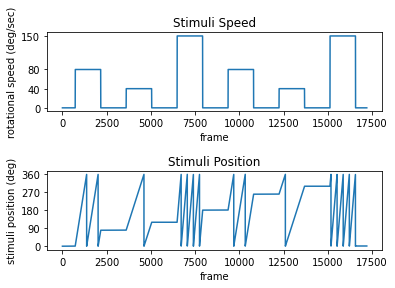

In [4]:
stimuliDf = uvr.stmDf
print(stimuliDf.head())

fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.75})

axs[0].plot(stimuliDf['rotSpeed'])
axs[0].set_yticks(stimuliDf.drop_duplicates(subset=['rotSpeed'])['rotSpeed'])
axs[0].set_xlabel("frame")
axs[0].set_ylabel("rotational speed (deg/sec)")
axs[0].set_title("Stimuli Speed")

axs[1].plot(stimuliDf['azimuth'])
axs[1].set_yticks(range(0,360+1,90))
axs[1].set_xlabel("frame")
axs[1].set_ylabel("stimuli position (deg)")
axs[1].set_title("Stimuli Position")


#### Plot trajectory

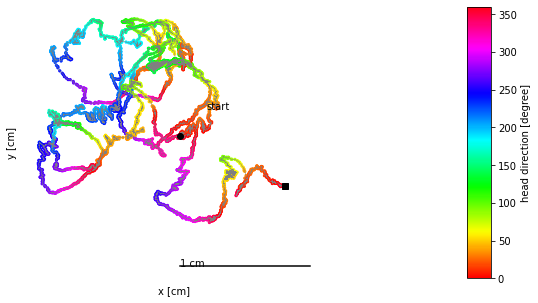

In [5]:
#conversion factor to cm
dc2cm = 10

fig, axs = viz.plotFlyPath(uvr, dc2cm, figsize=(10,5))
utils.pathPlotAxisTheme(axs[0],'cm')
utils.plotScaleBar(axs[0],1,(0,-1),'1 cm')

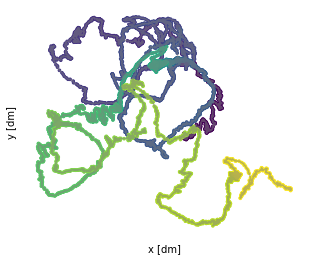

In [6]:
# Plot trajectory witth objects (all in decimeter)
fig, ax = viz.plotVRpathWithObjects(uvr,limx=[-np.inf, -np.inf],limy=[-np.inf, -np.inf], myfigsize=(5,5))
utils.pathPlotAxisTheme(ax,'dm')
# utils.plotScaleBar(ax,1,(0.2,0),'1 dm')

### Plot Rotational Velocity

In [7]:
def calculate_stimuli_windows(trial_length, motion_length=10, static_length=5):
    """Return a list of start and stop times for periods of movement in a moving gratings trial. 
    A moving gratings trial is made up of segments with motion that is static before and after.

    Args:
        trial_length (float): duration of trial in seconds
        motion_length (float, optional): duration of moving stimulus in seconds. Defaults to 10.
        static_length (float, optional): duration of static stimulus in seconds. Defaults to 5.

    Returns:
        List[List]: A list of windows, where each window is a list containing the start and stop time
    """
    segment_length = 2 * static_length + motion_length
    start_times = np.arange(0, trial_length, segment_length) + static_length
    stimuli_windows = [[start, start+10] for start in start_times]
    return stimuli_windows

In [8]:
def get_stimuli_windows(stmDf):
    # Given untiy vr dataframes
    # find windows of non-zero speeds
    # Return list of dicts, each containg a window and the speed during that window
    movement_windows = []
    df_groups = stmDf.groupby((stmDf['rotSpeed'].shift() != stmDf['rotSpeed']).cumsum())
    for k, v in df_groups:
        group_start_row = v.drop_duplicates(subset=['rotSpeed'])
        # if (group_start_row['rotSpeed'] == 0).any():
        #     continue
        # else:
        start_time = group_start_row['time'].array[0]
        # Get time at end of last frame (time column shows time at the begining of frame)
        end_time_df = stmDf[stmDf['frame'] == v.iloc[-1]['frame'] + 1]['time']
        if len(end_time_df.array) == 0:
            end_time = v.iloc[-1]['time']
        else:
            end_time = end_time_df.array[0]
        window = [start_time, end_time]
        speed = group_start_row['rotSpeed'].array[0]
        movement_windows.append({'window': window, 'speed': speed})

    return pd.DataFrame(movement_windows)

In [9]:
uvr.posDf

,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt
0,1.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.0,0.021073,0.001073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4.0,0.029763,0.008690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,0.032058,0.002295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
17201,17202.0,119.414543,0.006942,0.080518,-0.038759,359.549825,-0.000023,-0.000058,-0.000023,-0.000058
17202,17203.0,119.421486,0.006941,0.080518,-0.038759,359.549825,0.000000,0.000000,0.000000,0.000000
17203,17204.0,119.428436,0.006947,0.080875,-0.039160,359.831853,0.000361,-0.000398,0.000361,-0.000398
17204,17205.0,119.435371,0.006937,0.080937,-0.038998,0.130707,0.000062,0.000163,0.000062,0.000163


In [10]:
uvr.stmDf

,frame,time,azimuth,elevation,round,rotSpeed
0,1.0,0.000000,0.000000,0.0,0.0,0.0
1,2.0,0.020000,0.000000,0.0,0.0,0.0
2,3.0,0.021073,0.000000,0.0,0.0,0.0
3,4.0,0.029763,0.000000,0.0,0.0,0.0
4,5.0,0.032058,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...
17201,17202.0,119.414543,1.052246,0.0,15.0,0.0
17202,17203.0,119.421486,1.052246,0.0,15.0,0.0
17203,17204.0,119.428436,1.052246,0.0,15.0,0.0
17204,17205.0,119.435371,1.052246,0.0,15.0,0.0


In [11]:
# Process data
posDf = uvr.posDf
posAnalysis.computeVelocities(posDf)
posAnalysis.position(uvr, derive=True)
posDf.tail()

,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt,vT,vR,vT_filt,vR_filt,ds,s,dTh,radangle
17201,17202.0,119.414543,0.006942,0.080518,-0.038759,359.549825,-0.000023,-0.000058,-0.000023,-0.000058,0.045304,-0.199479,0.240742,0.094373,0.000063,8.992571,-0.398959,-0.007857
17202,17203.0,119.421486,0.006941,0.080518,-0.038759,359.549825,0.000000,0.000000,0.000000,0.000000,0.387114,0.141014,0.262594,-0.340492,0.000000,8.992571,0.000000,-0.007857
17203,17204.0,119.428436,0.006947,0.080875,-0.039160,359.831853,0.000361,-0.000398,0.000361,-0.000398,0.347419,-0.638778,0.355958,-0.482578,0.000537,8.993108,0.282028,-0.002935
17204,17205.0,119.435371,0.006937,0.080937,-0.038998,0.130707,0.000062,0.000163,0.000062,0.000163,0.510258,-0.311668,0.536513,-0.160587,0.000174,8.993283,0.298853,0.002281
17205,17206.0,119.442322,0.006949,0.080670,-0.038483,1.066956,-0.000266,0.000515,-0.000266,0.000515,0.835069,0.936249,0.826459,0.853544,0.000580,8.993863,0.936249,0.018622


In [12]:
posDf['dt'].describe()

count    17206.000000
mean         0.006943
std          0.000238
min          0.001073
25%          0.006940
50%          0.006943
75%          0.006947
max          0.020000
Name: dt, dtype: float64

In [13]:
def plot_windows(ax, windows_df, speeds, cmap='Wistia'):
    for window_row in windows_df.itertuples():
        window = window_row.window
        ylim = ax.get_ylim()
        xy = [window[0], ylim[0]]
        width = window[1] - window[0]
        height = ylim[1] - ylim[0]
        
        color_index = speeds.index(window_row.speed)
        colormap = matplotlib.cm.get_cmap(cmap)
        if window_row.speed == 0:
            continue
        else:
            color = colormap((color_index+1)/(len(speeds)+1))

        window_patch = Rectangle(xy=xy, width=width, height=height, color=color)
        ax.add_patch(window_patch)
    return ax

In [14]:
def get_df_in_windows(posDf, windows):
    all_window_rows = None
    for index, window in enumerate(windows):
        window_rows = (window[0] < posDf['time']) & (posDf['time'] < window[1])
        if index == 0:
            all_window_rows = window_rows

        all_window_rows = all_window_rows | window_rows

    return posDf[all_window_rows]

In [15]:
def plot_histogram(ax, posDf, windows, bins=11, range=None, color='gray'):
    velo = get_df_in_windows(posDf, windows)['vR_filt']
    ax.hist(velo, color=color,bins=bins,range=range)

In [16]:
def plot_rotational_behavior(uvr, cmap='Wistia'):
    # Plot angle over time

    hist_names = [f'hist_{x}' for x in ['a','b','c','d']]
    panel_names = [f'panel_{x}' for x in ['a','b','c']]
    mosaic = [['panel_a']*4,
              ['panel_b']*4,
              ['panel_c']*4,
              hist_names]
    fig, axd = plt.subplot_mosaic(mosaic, figsize=(10,6),
                                  gridspec_kw={'height_ratios':[1,1,1,2],
                                               'hspace':0.3,
                                               'wspace':0})

    velo = uvr.posDf['vR_filt']
    window_length = int( 0.2/uvr.posDf['dt'].mean())
    print(f"window length: {window_length} frames")
    rolling_avg_vel = uvr.posDf['vR'].rolling(window=window_length).mean()
    angle = np.unwrap(uvr.posDf['radangle'])
    time = uvr.posDf['time']
    
    axd['panel_a'].plot(time, angle)
    axd['panel_a'].set_ylabel("Position (rad)")

    axd['panel_b'].plot(time, velo)
    axd['panel_b'].set_ylabel("Velocity (deg)")

    axd['panel_c'].plot(time, rolling_avg_vel)
    axd['panel_c'].set_ylabel("Rolling Average Velocity (deg)")

    speeds = list(uvr.stmDf.drop_duplicates(subset=['rotSpeed'])['rotSpeed'].array)

    stimuli_windows = get_stimuli_windows(uvr.stmDf)
    for char in ['a','b','c']:
        plot_windows(axd[f'panel_{char}'], stimuli_windows, speeds, cmap=cmap)
        axd[f'panel_{char}'].set_xticks([])

    # plot histograms of different speeds
    colormap = matplotlib.cm.get_cmap(cmap)
    for index, (speed, char) in enumerate(zip(speeds, ['a','b','c','d'])):
        # print(index, speed, char)
        windows = stimuli_windows[stimuli_windows['speed'] == speed]['window']
        if speed == 0:
            color = 'darkgray'
        else:
            color = colormap((index+1)/(len(speeds)+1))

        plot_histogram(axd[f'hist_{char}'], uvr.posDf, windows, bins=21, range=[-3,3], color=color)
        axd[f'hist_{char}'].set_title(f"{speed} °/s stimuli", fontsize=10)
    
    # Use max xlim and ylim for all histograms
    xlim_bound = [None]*2
    ylim_bound = [None]*2
    for index, hist_name in enumerate(hist_names):
        xlim = axd[hist_name].get_xlim()
        ylim = axd[hist_name].get_ylim()
        if index == 0:
            xlim_bound = xlim
            ylim_bound = ylim
        else:
            if xlim[0] < xlim_bound[0]:
                xlim_bound[0] = xlim[0]
            if xlim[1] > xlim_bound[1]:
                xlim_bound[1] = xlim[1]
            if ylim[1] > ylim_bound[1]:
                ylim_bound[1] = ylim[1]

    for index, hist_name in enumerate(hist_names):
        axd[hist_name].axvline(0, linestyle='--', color='dimgray')
        # axd[hist_name].set_yscale("log")
        axd[hist_name].set_xlim(xlim_bound)
        axd[hist_name].set_ylim(ylim_bound)
        if index != 0:
            axd[hist_name].set_yticks([])
        if index == 0:
            axd[hist_name].set_ylabel("counts")
        axd[hist_name].set_xlabel("Velocity (°/s)")


    return fig

window length: 28 frames


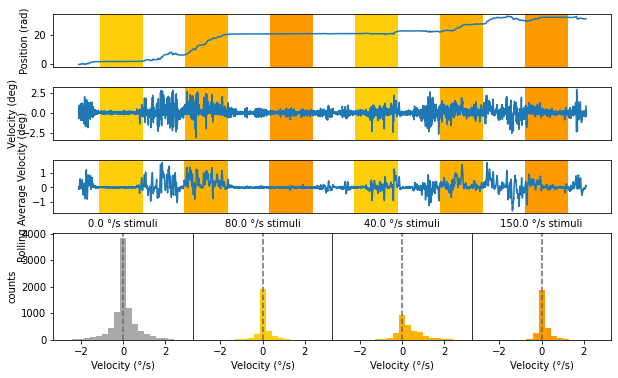

In [17]:
fig = plot_rotational_behavior(uvr)

In [18]:
def get_df_in_windows(posDf, windows):
    all_window_rows = None
    for index, window in enumerate(windows):
        window_rows = (window[0] < posDf['time']) & (posDf['time'] < window[1])
        if index == 0:
            all_window_rows = window_rows

        all_window_rows = all_window_rows | window_rows

    return posDf[all_window_rows]

[[0.0, 5.005244255065918], [25.00586700439453, 35.004600524902344]]
[[5.005244255065918, 15.005546569824219], [35.004600524902344, 45.002159118652344]]
[[15.005546569824219, 25.00586700439453], [45.002159118652344, 55.00666046142578]]


Text(0, 0.5, 'count')

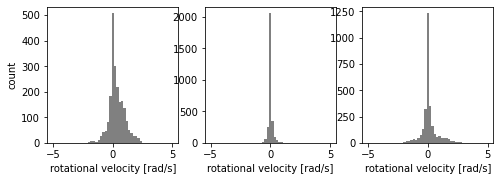

In [22]:
# Plot histogram
nBins = 51
binRange = [-5, 5]
xlim = binRange
xlabel = "Rotational Velocity"
stimuli_windows = get_stimuli_windows(uvr.stmDf)

fig, axs = plt.subplots(1, 3, figsize=(8,2.5))
for index, ax in enumerate(axs):
    windows = [stimuli_windows.iloc[index]['window'], stimuli_windows.iloc[index+3]['window']]
    print(windows)
    velo = get_df_in_windows(uvr.posDf, windows)['vR_filt']
    
    ax.hist(velo, color='grey',bins=nBins,range=binRange)
    # Create a histogram for each speed
    ax.set_xlabel('rotational velocity [rad/s]')

axs[0].set_ylabel('count')

### Plot all control trials

In [23]:
def get_trial_filenames(dirName, key):
    fileNames = []
    for root, dirs, files in os.walk(dirName):
        if root == dirName:
            for file in files:
                if key is None:
                    fileNames.append(file)
                elif key in file:
                    fileNames.append(file)
                
        else:
            break
    return fileNames

In [24]:
control_trials = []
for fileName in get_trial_filenames(dirName, "2023-05-26"):
    trial = lp.constructUnityVRexperiment(dirName,fileName)
    control_trials.append(trial)
    

correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.
correcting for Unity angle convention.


In [25]:
for trial in control_trials:
    posAnalysis.computeVelocities(trial.posDf)
    posAnalysis.position(trial, derive=True)

window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames
window length: 28 frames


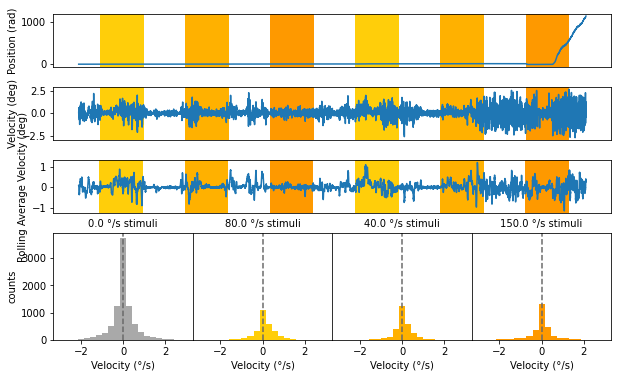

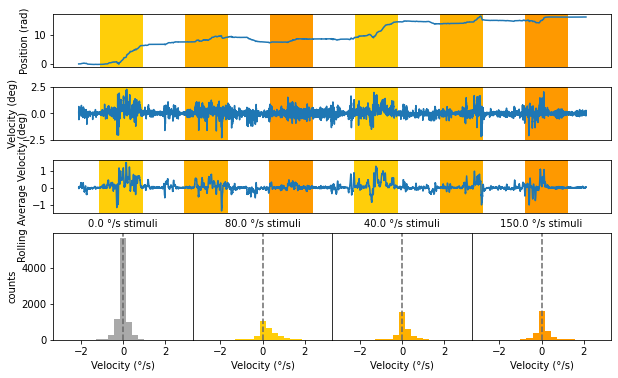

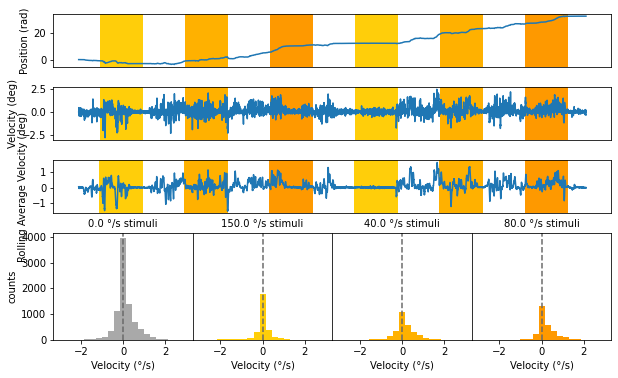

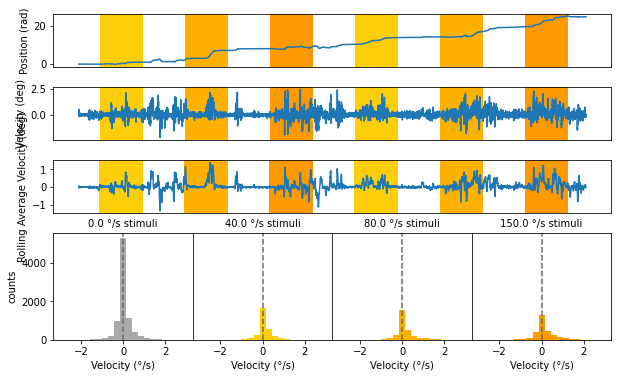

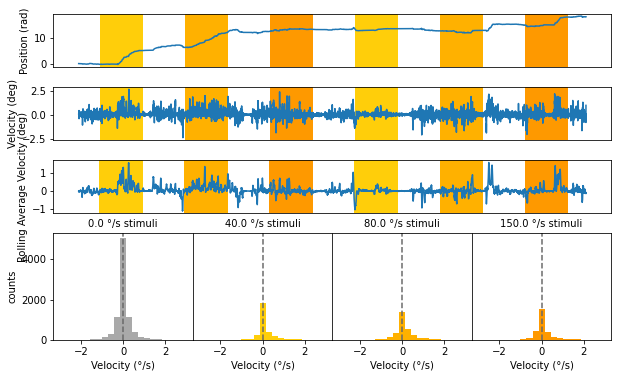

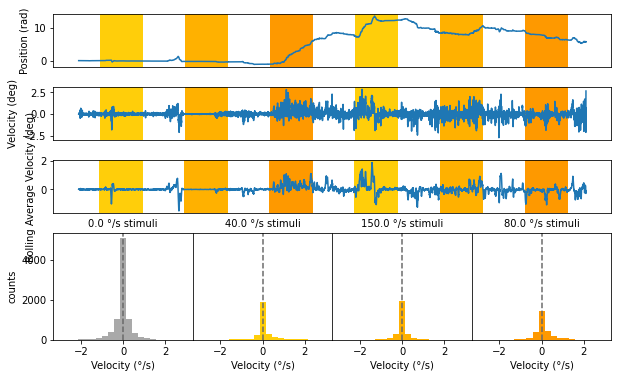

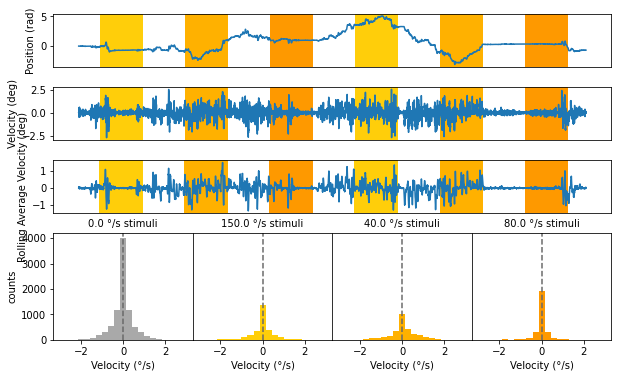

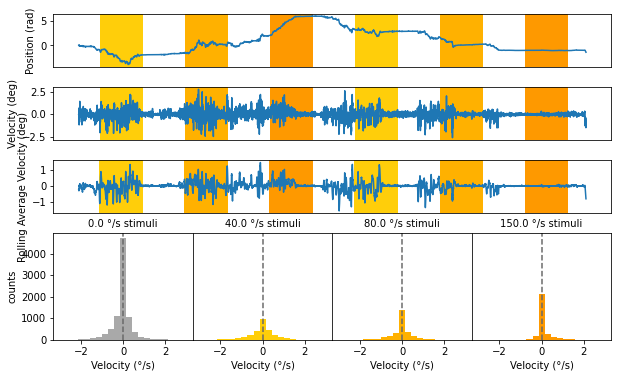

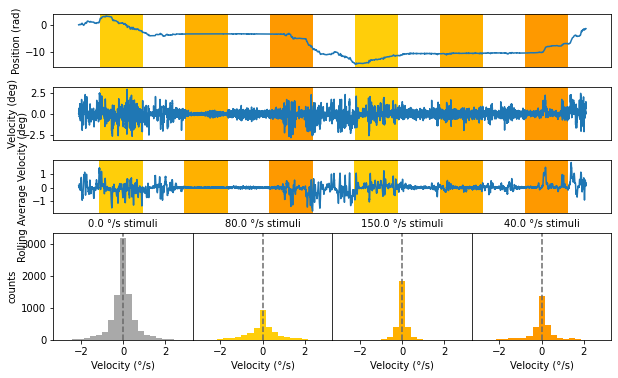

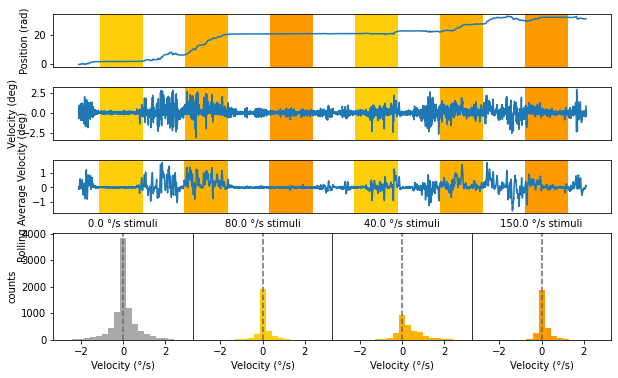

In [26]:
# print(control_trials)
for trial in control_trials:
    fig = plot_rotational_behavior(trial)
    time = trial.metadata['time']
    date = trial.metadata['date']
    # print(trial.metadata)
    name = f"{date}_{time}"
    parent = Path("..", "results", "plots", "control")
    fig.savefig(Path(parent, name), dpi=600)